## Getting Set Up 

#### What programs you will need installed: 
- Anaconda 5.0.1 with Python 3.6   
https://www.anaconda.com/download/   
-- Python 3.6 for its better handling of text data  
-- Anacond for its collection of popular data science libraries and packages.

 
- XGboost   
-- Arguably the most popular classifer package

You can install XGBoost at the comand line via:

- Embeddings Data  

You will also need the Data for today, which is available at:

https://github.com/GeorgeMcIntire/fake_real_news_dataset

## What We Will Cover

1. Logistic classifier 
2. Metrics: precision, recal, F1
3. XGBoost classifer 
4. Embedded text


## 1) Logistic Regression

#### Binary Classification

In a binary classification problem, we try to predict a binary outcome and we assign labels of 0 and 1 to our data.

Here are some example questions:

* Does a patient have cancer?
* Will a team win the next game?
* Will the customer buy my product?
* Will I get the loan?
* Is this article fake?


Let's start by looking at an example. We're going to be using some NFL data. The x axis is the number of touchdowns scored by team over a season and the y axis is whether they lost or won the game indicated by a value of 0 or 1 respectively.

![NFL data](images/nfl.png)

So, how do we predict whether we have a win or a loss if we are given a score? Note that we are going to be predicting values between 0 and 1. Close to 0 means we're sure it's in class 0, close to 1 means we're sure it's in class 1, and closer to 0.5 means we don't know.

If we use linear regression for the NFL example above, we will certainly do better than randomly guessing, but it doesn't accurately represent the data:

![NFL linear regression](images/linefit.png)

So clearly a line is not the best way to model this data. So we need to find a better curve.

### The Logistic Function

First, we will just pull a function out of the data science bag of tricks and show that it works reasonably well.

And, second, we are going to understand how we came up with that function and how it is related to binary outcomes and odds. But before that let's understand this a bit better.

This function will need to have a value of 0 for the loss scores and 1 for the win scores. To make sense it will need to be 0 for some score and all scores below it and be 1 for some other score and all scores above it. And it will need to smoothly increase from 0 to 1 in the intermediate range.

It will need to look something like this:

![logistic](images/standardLogisticFunction.png)


A function that has the above shape is:

$$ f(t) = \frac{e^t}{1 + e^t} = \frac{1}{1 + e^{-t}} $$

This is the logistic function, also known as the sigmoid function. Note that as t approaches infinity, the value of the logistic function approaches 1 and as t approaches negative infinity, the value of the logistic function approaches 0.

We will use $ t = \beta_0 + \beta_1x $, which means we'll be dealing with a familiar looking linear function.  

This gives us:

$$ p(x) = \frac{e^{\beta_0 + \beta_1 x}}{1 + e^{\beta_0 + \beta_1 x}} = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} $$

* p(x) is our hypothesis and it represents the probability of a score of x leading to a win. 

\begin{align*}
& P(Y = 1 | X) = p(X) \\
& P(Y = 0 | X) = 1 - p(X)\\
\end{align*}

* $\beta_0$ and $\beta_1$ are parameters that we will optimize to best fit our data.

In [2]:
# inital imports 

# pandats is like a more powerful version of excel, we're using it to read a .csv file and manipulate tables
import pandas as pd
# a very popular graph plotting library 
import matplotlib.pyplot as plt
# makes matplotlib look a bit better 
import seaborn
# this makes the plots display in the notebook (here) rather than open as a file 
%matplotlib inline

In [3]:
# Load the dataset into pandas: data/grad.csv
df = pd.read_csv('data/grad.csv')

# view the first 5 rows 
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [3]:
# Use the pandas describe method to get some preliminary summary statistics on the data. 
# In particular look at the mean values of the features.
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


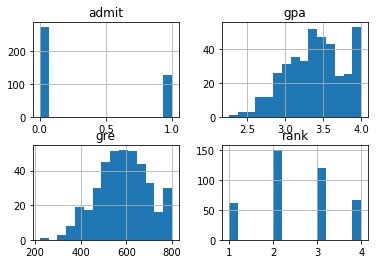

In [4]:
# look at the distribution of values 
pd.DataFrame.hist(df, bins=15);

In [4]:
# data transformation  

import numpy as np

X = np.asarray(df[['gre','gpa','rank']])
X = np.insert(X, 0, 1, axis=1)             #  11111111111111!
y = np.asarray(df['admit'])

# data preprocessing - normalization 

X_norm = (X - X.mean(axis=0)) / (X.max(axis=0) - X.min(axis=0)) # normed by col
X_norm = np.insert(X_norm, 0, 1, axis=1)                        # col of 1s                         
y = np.asarray(df['admit'])                                     # true values
print(X_norm)

[[ 1.                 nan -0.35810345  0.12649425  0.17166667]
 [ 1.                 nan  0.12465517  0.16097701  0.17166667]
 [ 1.                 nan  0.36603448  0.35063218 -0.495     ]
 ..., 
 [ 1.                 nan -0.22017241 -0.43672414 -0.16166667]
 [ 1.                 nan  0.19362069  0.14948276 -0.16166667]
 [ 1.                 nan  0.0212069   0.28741379  0.17166667]]


/Users/mtamir/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test sets
seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [14]:
# instantiate a logistic regression model, and fit with X and y
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# check the accuracy on the training set
model.score(X_test, y_test)

0.75

#### But wait, what exactly does that number mean? 


### Accuracy
The simplest measure is **accuracy**. This is the number of correct predictions over the total number of predictions. It's the percent you predicted correctly. In `sklearn`, this is what the `score` method calculates.

### Shortcomings of Accuracy
Accuracy is often a good first glance measure, but it has many shortcomings. If the classes are unbalanced, accuracy will not measure how well you did at predicting. Say you are trying to predict whether or not an email is spam. Only 2% of emails are in fact spam emails. You could get 98% accuracy by always predicting not spam. This is a great accuracy but a horrible model!

### Confusion Matrix
We can get a better picture our model but looking at the confusion matrix. We get the following four metrics:

* **True Positives (TP)**: Correct positive predictions
* **False Positives (FP)**: Incorrect positive predictions (false alarm)
* **True Negatives (TN)**: Correct negative predictions
* **False Negatives (FN)**: Incorrect negative predictions (a miss)

|            | Predicted Yes  | Predicted No   |
| ---------- | -------------- | -------------- |
| Actual Yes | True positive  | False negative |
| Actual No  | False positive | True negative  |

With logistic regression, we can visualize it as follows:

![logistic confusion matrix](images/logistic.png)


## 2) Metrics 

In [20]:
from sklearn.metrics import classification_report

target_names = ['Not Admitted', 'Admitted']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Admitted       0.74      1.00      0.85        90
    Admitted       1.00      0.24      0.38        42

 avg / total       0.82      0.76      0.70       132



71.5% accuracy only tells part of the story.  

### Precision, Recall and F1

![](http://i.stack.imgur.com/ysM0Z.png)
Instead of accuracy, there are some other scores we can calculate:

* **Precision**: A measure of how good your positive predictions are
    ```
    Precison = TP / (TP + FP)
             = TP / (predicted yes)
    ```
* **Recall**: A measure of how well you predict positive cases. Aka *sensitivity*.
    ```
    Recall = TP / (TP + FN) 
           = TP / (actual yes)
    ```
* **F1 Score**: The harmonic mean of Precision and Recall
    ```
    F1 = 2 / (1/Precision + 1/Recall)
       = 2 * Precision * Recall / (Precision + Recall)
       = 2TP / (2TP + FN + FP)
    ```

Accuracy can also be written in this notation:
```
Accuracy = (TP + TN) / (TP + FP + TN + FN)
```

![](http://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)


## 3) A More Advanced Classifier 

## Random Forests

Probably the most common ensemble method is a *Random Forest*, which consists of a collection of Decision Trees.

They were developed by Leo Breimen, who has the most extensive notes about them on his [webpage](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm).

The idea is to repeatedly randomly select data from the dataset (*with replacement*) and build a Decision Tree with each new sample. The default is to have the randomly selected data be the same size as the initial dataset. Note that since we are sampling with replacement, many data points will be repeated in the sample and many won't be included.

Random Forests also limit each node of the Decision Tree to only consider splitting on a random subset of the features.

Here is the pseudocode for creating a Random Forest:

    CreateRandomForest(data, num_trees, num_features):
        Repeat num_trees times:
            Create a random sample of the test data with replacement
            Build a decision tree with that sample (only consider num_features features at each node)
        Return the list of the decision trees created

To classify a new document, use each tree to get a prediction. Choose the label that gets the most votes.

The default parameters that sklearn uses, which are also standard defaults, are 10 trees and only considering sqrt(m) features (where m is the total number of features).


### Out of Bag Error

We can analyze a Random Forest using the standard cross validation method of splitting the dataset into a training set and a testing set. However, if we're clever, we notice that each tree doesn't see all of the training data, so we can use the skipped data to cross validate each tree individually.

We'll skip the mathematical proof, but when selecting from the dataset, about one third of the data is left out (discussed [here](http://math.stackexchange.com/questions/203491/expected-coverage-after-sampling-with-replacement-k-times) if you want to think about the math). So every data point can be tested with about 1/3 of the trees. We calculate the percent of these that we get correct, and this is the *out-of-bag error*.

It has been proven that this is sufficient and that cross validation is not strictly necessary for a random forest, but we often still use it as that makes it easier to compare with other models.


### Feature Importance

We can use the random forest to determine which features are the most importance in predicting the class.

Breiman, the originator of random forests, uses out-of-bag error to determine feature importance, discussed [here](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp). The idea is to compare the out-of-bag error of the trees with the out-of-bag error of the trees if you change the feature's value (basically, if we screw with the value of the feature, how much does that impact the total error?). Here is the pseudocode for calculating the feature importance for a single feature:

        For every tree:
            Take the data that is not covered by the tree.
            Randomly permute the values of the feature (i.e. keep the same values,
                but shuffle them around the data points).
            Calculate the OOB error on the data with the feature values permuted.
            Subtract the permutated OOB from the OOB of the original data to get the
                feature importance on this tree.
        Average all the individual feature importances to get the feature importance.

sklearn uses a different method, described [here](http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation). Their method doesn't involve using the out-of-bag score. Basically, the higher in the tree the feature is, the more important it is in determining the result of a data point. The expected fraction of data points that reach a node is used as an estimate of that feature's importance for that tree. Then average those values across all trees to get the feature's importance.

## Boosting in General

You will often hear the word "Bagging" dropped around the same time as "Boosting." The two are very different techniques and not really used in the same context. You already know what bagging is. 

Boosting, properly stated, the use of the output of one model as the input of another. Thus we can use Pipelines to construct whole groups of models that are technically "boosted" by each other. Any and all models can be boosted, according to the theory. 

The word "boosting" is most commonly used to describe boosting used with trees, and most particularly Gradient Boosted Regression Trees (GBRTs). You can think of it as "combining weak learners" to make a "strong learner". This is mumbo-jumbo. The "weak" learners are just normal decision trees (as opposed to an estimator which is especially "weak" in some way). 

## Boosting in Trees

There are two types of boosting used in trees in common practice today. This is the most common jargon usage of this word in data science. If you hear fellow data scientists say "boosting", they are often referring to boosted trees.

### Adding bias into the training process

 In the boosted tree algorithms, a "family" of trees is "grown" over successive generations of trees, by making each successor tree an expert on attacking the weaknesses of the other. What results is a single "master" tree designed to defeat all weaknesses of the training set selection. Members of the family are weighted by the ratio of errors not covered by the previous members. 

The process of boosting (in any case) is based on measuring the degree to which a given tree fails in making a good prediction. This, of course, is the cost or more commonly in the case of trees "loss" function.

### Some notes about the boosting community
1. They try to make algorithms sound like products ("LogitBoost","AnyBoost", etc.)
2. "loss function" = cost function
3. "weak learners" = normal estimators
4. "model is complex/review of the theory" = we don't understand it very well/it's all Black Magic to us

One method of boosting is called AdaBoost it looks like:

![adaboost_part](./images/AdaBoost_part.png)

Another is Gradient booting:
![gradient_boosting_scheme](./images/GradientBoosting_scheme.png)

## Why does any of this work?

Most of the machine learning community seems baffled by the success of this approach, and in general, GB tends to outperform even very sophisticated methods, including neural networks. 

Why? The intuition is that the algorithm ends up partitioning on the noise rather than the signal. What I think happens is that signal gets partitioned into a few relatively powerful trees (perhaps 1/5th to 1/3 of them), and most of the trees are set up to shunt out the noise. I suspect that the weights (lagrange multipliers) provide a degree of freedom so that probably reflects the dominance of that particular noise, not unlike an eigenvector/eigenvalue relationship.

Trying to get a clear statement like that out of famous people like Hastie or Tibishirani seems impossible. Maybe because they're afraid they might be wrong.

In [69]:
from xgboost import XGBClassifier

XGmodel = XGBClassifier(max_depth=7, learning_rate=0.2, 
                        n_estimators=1000, silent=True, 
                        objective='binary:logistic', nthread=-1, 
                        gamma=0, min_child_weight=1, max_delta_step=0, 
                        subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, reg_alpha=0, 
                        reg_lambda=1, scale_pos_weight=1, 
                        base_score=0.5, seed=0, missing=None)

XGmodel.fit(X_train, y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [30]:
y_pred = XGmodel.predict(X_test)

target_names = ['Not Admitted', 'Admitted']

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Admitted       0.72      0.81      0.76        90
    Admitted       0.45      0.33      0.38        42

 avg / total       0.64      0.66      0.64       132



Note, boosting performed worse than Logistic Regression here. Why do you think that is?

## 4) Embedded Text 

Remember those familiar column names?

In [36]:
print(list(df.columns))

['admit', 'gre', 'gpa', 'rank']


What if we didn't know the test scores or the rank of the student in the class?  

What if all we had were the student's essays?  

In that case, our problem is a little harder. First, we need to decide what our colums are going to be. What is a feature of an essay? What aspects or parts of the essays do we care about? Once we know that we have to read each one and enter values for each student for each column, according to what they wrote.

We could do that ourselves, but it would take a very long time.  

In machine learning there is a concept called an *embedding*. Embeddings are where we choose how many columns and the computer/algorithm/AI chooses what aspect goes in each one, then scores the essays for us in each column. 

In [83]:
df = pd.read_csv('data/onion_reuters_embeddings.csv', sep='\s+', header=None)

df.tail()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
19995,-5.230067,-3.597191,-3.962436,4.357621,-8.503902,2.594657,1.948463,-4.259420,-7.848333,-0.198398,...,2.696597,2.526998,2.212848,6.105873,5.207789,-1.095498,-8.406791,1.995144,2.922570,1.0
19996,8.655161,3.216463,3.180928,3.735920,1.518733,6.659177,3.347452,-0.577658,-7.307533,-8.166327,...,1.056458,4.289464,11.064774,3.595927,0.350768,5.447138,-1.876241,8.191900,-4.402915,1.0
19997,5.787154,3.571592,1.132058,-0.635032,2.682277,8.982737,-0.363522,-0.991837,-1.214867,-0.102986,...,4.381866,0.025675,1.275467,0.232545,4.025445,5.082364,1.341273,2.689050,-0.143825,1.0
19998,-2.560885,-7.999623,-8.849792,3.775523,-6.862742,-2.963762,7.276275,2.637631,-0.669727,3.637837,...,11.104369,9.130438,2.408080,-0.311689,0.189652,-1.000840,-4.385654,-1.742498,-1.524839,1.0
19999,-0.025104,-0.688953,-3.751254,1.800386,0.176604,2.892242,-2.041802,-3.385113,0.674931,-3.920923,...,6.433015,0.781282,-2.134592,0.244282,5.747131,1.039919,-7.127241,-3.419089,2.414535,1.0


In [85]:
len(df.columns)

51

In [86]:
df.columns[-1]

50

In [5]:
df = pd.read_csv('data/fake_or_real_news.csv', )

df.tail()

,Unnamed: 0,title,text,label
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


## 5) Class Activity 

Pick your favorite classifier and find the fake articles! 